# Exploring  gpx files

In this assignment we begin by first learning how to explore a gpx file. A GPX file format is more like an XML document text.

Let's now import some useful libraries that we will need to perform our exploration.

In [1]:
%%time
import gpxpy
import matplotlib.pyplot as plt
import datetime
from geopy import distance
from math import sqrt, floor
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import haversine
import vincenty

Wall time: 3.25 s


Now here is how to load and explore the data inside a GPX file. 

The file we are going to use here just represents a single journey taken by an athlete we'll call 'Athlete13'.

The size of the file **1.gpx** was **716 KB**. It contains data from a single journey.

In [2]:
%%time
import gpxpy
gpx = gpxpy.parse(open('1.gpx'))

print("{} track(s)".format(len(gpx.tracks)))
track = gpx.tracks[0]

print("{} segment(s)".format(len(track.segments)))
segment = track.segments[0]

print("{} point(s)".format(len(segment.points)))



1 track(s)
1 segment(s)
1809 point(s)
Wall time: 1.51 s


In [3]:
!du -sh 1.gpx

720K	1.gpx


Next we will extract the data for all those journey points in our file.

In [4]:
%%time
data = []
segment_length = segment.length_3d()
for point_idx, point in enumerate(segment.points):
    data.append([point.longitude, point.latitude,
                 point.elevation, point.time, segment.get_speed(point_idx)])
    
from pandas import DataFrame

columns = ['Longitude', 'Latitude', 'Altitude', 'Time', 'Speed']
df = DataFrame(data, columns=columns)
df.head()

Wall time: 170 ms


,Longitude,Latitude,Altitude,Time,Speed
0,16.173866,46.538402,132.399994,2014-04-07 12:57:11+00:00,1.788874
1,16.173844,46.538406,132.399994,2014-04-07 12:57:12+00:00,2.242370
2,16.173710,46.538436,132.399994,2014-04-07 12:57:16+00:00,3.321679
3,16.173465,46.538491,132.399994,2014-04-07 12:57:21+00:00,5.537861
4,16.173376,46.538510,132.399994,2014-04-07 12:57:22+00:00,7.124480


In [5]:
df.describe()

,Longitude,Latitude,Altitude,Speed
count,1809.000000,1809.000000,1809.000000,1809.000000
mean,16.089109,46.551284,149.611498,8.500514
std,0.061725,0.019865,10.931190,1.335174
min,16.006548,46.518628,131.600006,0.000000
25%,16.026218,46.538953,140.199997,7.984415
50%,16.082296,46.549758,148.800003,8.464529
75%,16.147256,46.562750,159.399994,8.930430
max,16.194670,46.595207,175.600006,13.539542


Our next goal is to plot the direction of movement. 

We will use the **sw.dist** function from the **seawater** library to compute some angles. 

We will then use those angles to calculate the velocity components u and v. These components are associated to each speed data.

Since GPX data from smart phones can be very noisy we'll try to smooth it to enhance our plot. For this we used **smool** from the **oceans.filters** module

In [6]:
# df['Time'] = pd.to_datetime(df['Time'], format='%d%b%Y:%H:%M:%S.%f')

In [7]:
%%time
import numpy as np
import seawater as sw
from oceans.filters import smoo1

_, angles = sw.dist(df['Latitude'], df['Longitude'])
angles = np.r_[0, np.deg2rad(angles)]

# Normalize the speed to use as the length of the arrows
r = df['Speed'] / df['Speed'].max()
kw = dict(window_len=31, window='hanning')
df['u'] = smoo1(r * np.cos(angles), **kw)
df['v'] = smoo1(r * np.sin(angles), **kw)

Wall time: 25.2 ms


To plot the track and the direction we will employ **mplleaflet** module

In [8]:
%%time
import mplleaflet
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
df = df.dropna()
ax.plot(df['Longitude'], df['Latitude'],
        color='darkorange', linewidth=5, alpha=0.5)
sub = 10
ax.quiver(df['Longitude'][::sub], df['Latitude'][::sub], df['u'][::sub], df['v'][::sub], color='deepskyblue', alpha=0.8, scale=10)
mplleaflet.display(fig=fig, tiles='esri_aerial')

Wall time: 2.18 s


C:\Users\SPN\anaconda3\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


We discovered from the plot that the athlete was running/cycling at some place in Europe.

And below is how the plot would look like while using **matplotlib** module

Wall time: 35.2 ms


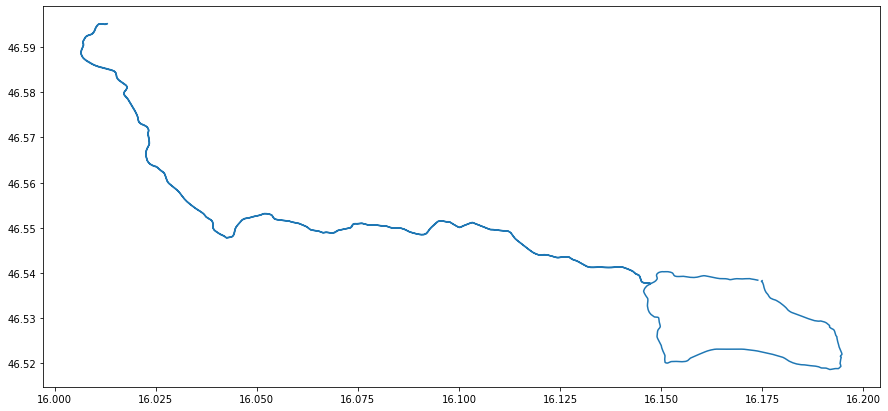

In [9]:
%%time
fig = plt.figure(figsize=(15, 7))
plt.plot(df['Longitude'], df['Latitude'])

Next, we used **Reverse geocoding** software to convert the latitude and longitude coordinates (of the starting point) to a readable address. 

We discovered that the athlete started running/cycling at a place called **Noršinci pri Ljutomeru 21B, 9240 Ljutomer, Slovenija**

We then plotted that location using Basemap.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


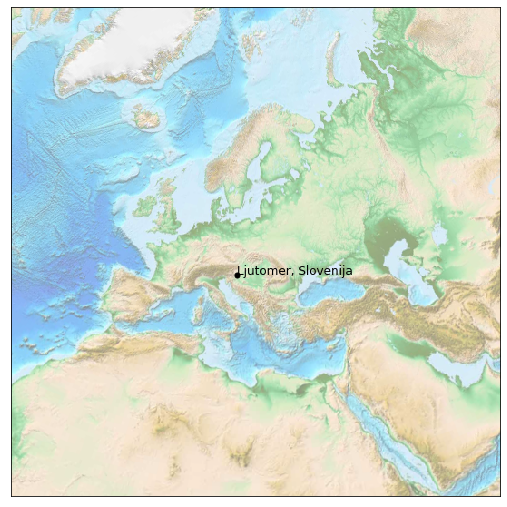

In [10]:
import os
os.environ['PROJ_LIB'] = '/home/YOUR_USER/anaconda3/share/proj'
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(9, 9))
m = Basemap(projection='lcc', resolution=None,
            width=8E6, height=8E6, 
            lat_0=50, lon_0=20,)
m.etopo(scale=0.5, alpha=0.5)

# Map (long, lat) to (x, y) for plotting
x, y = m(16.173866,46.538402)
plt.plot(x, y, 'ok', markersize=5)
plt.text(x, y, 'Ljutomer, Slovenija', fontsize=12);

Next, we plot the runners path using **folium**

In [11]:
import pandas as pd
import folium

map_ = folium.Map(location=[46.538402,16.173866], zoom_start=10)

locs = df[['Latitude', 'Longitude']]
loc_list = locs.values.tolist()

# To display all data use the following two lines
for point in range(0, len(loc_list)):
    folium.Marker(loc_list[point]).add_to(map_)
    
map_

We then plot the minimum, maximum, and the starting point using **folium** module.

In [12]:
map2_ = folium.Map(location=[46.538402,16.173866], zoom_start=11)

folium.Marker([46.538402,16.173866], popup='Ljutomeru 21B, 9240 Ljutomer').add_to(map2_) 

folium.Marker([46.518628,16.006548], popup='Minimun point').add_to(map2_) 
  
folium.Marker([46.595207, 16.194670], popup='Maximum point').add_to(map2_) 
  
# Add a line to the map by using line method . 
# it connects both coordiates by the line 
# line_opacity implies intensity of the line 
folium.PolyLine(locations = [(46.518628,16.006548), (46.595207, 16.194670)], 
                line_opacity = 1.5).add_to(map2_)

map2_

We then plot the only the first 100 points of the  athlete's path.

In [13]:
import pandas as pd
import folium

map_ = folium.Map(location=[46.538402,16.173866], zoom_start=15)

locs = df[['Latitude', 'Longitude']].head(n=100)
loc_list = locs.values.tolist()

# To display all data use the following two lines
for point in range(0, len(loc_list)):
    folium.Marker(loc_list[point]).add_to(map_)
    
map_

In [14]:
#we tried plotting this, but it didn't work
# plt.plot(df['Time'], df['Altitude'])

There are two main approaches to calculate the distance between two points on a spherical surface: the Haversine distance and the Vincenty distance. We will use the **Haversine distance**

We’ll loop through the data points, and also create a list for the altitude difference, time difference and distance difference between all the consecutive data points.

In [15]:
data_ = gpx.tracks[0].segments[0].points

alt_dif = [0]
time_dif = [0]
dist_vin = [0]
dist_hav = [0]
dist_vin_no_alt = [0]
dist_hav_no_alt = [0]
dist_dif_hav_2d = [0]
dist_dif_vin_2d = [0]

for index in range(len(data_)):
    if index == 0:
        pass
    else:
        start = data_[index-1]
        
        stop = data_[index]
        
        distance_hav_2d = haversine.haversine((start.latitude, start.longitude), (stop.latitude, stop.longitude))*1000
        
        dist_dif_hav_2d.append(distance_hav_2d)
        
        dist_hav_no_alt.append(dist_hav_no_alt[-1] + distance_hav_2d)
        
        alt_d = start.elevation - stop.elevation
        
        alt_dif.append(alt_d)
        
        distance_hav_3d = sqrt(distance_hav_2d**2 + (alt_d)**2)
                
        time_delta = (stop.time - start.time).total_seconds()
        
        time_dif.append(time_delta)
        
        dist_hav.append(dist_hav[-1] + distance_hav_3d)

We then pour the data in our previously created dataframe.

In [16]:
df['dist_hav_2d'] = dist_hav_no_alt
df['dis_hav_3d'] = dist_hav
df['alt_dif'] = alt_dif
df['time_dif'] = time_dif
df['dis_dif_hav_2d'] = dist_dif_hav_2d

Let's see the results!

In [17]:
print('Haversine 2D : ', dist_hav_no_alt[-1])
print('Haversine 3D : ', dist_hav[-1])
print('Difference: ', dist_hav[-1]-dist_hav_no_alt[-1])
print('Total Time : ', floor(sum(time_dif)/60),' min ', int(sum(time_dif)%60),' sec ')

Haversine 2D :  43323.65661669579
Haversine 3D :  43329.49423896268
Difference:  5.837622266888502
Total Time :  85  min  47  sec 


### Multiples journeys taken by our athlete: Athlete 13

Our data contains multiple journeys taken by an athlete. Next, we'll load all the journeys into our notebook. And to accomplish that we make use of the **load_run_data** function created below.


In [18]:
import os
from glob import glob

def load_run_data(gpx_path, filter=""):
    gpx_files = glob(os.path.join(gpx_path, filter + "*.gpx"))
    run_data = []
    for file_idx, gpx_file in enumerate(gpx_files): 
        gpx = gpxpy.parse(open(gpx_file, 'r'))
        # Loop through tracks
        for track_idx, track in enumerate(gpx.tracks):
            track_name = track.name
            track_time = track.get_time_bounds().start_time
            track_length = track.length_3d()
            track_duration = track.get_duration()
            track_speed = track.get_moving_data().max_speed
            
            for seg_idx, segment in enumerate(track.segments):
                segment_length = segment.length_3d()
                for point_idx, point in enumerate(segment.points):
                    run_data.append([file_idx, os.path.basename(gpx_file), track_idx, track_name, 
                                     track_time, track_length, track_duration, track_speed, 
                                     seg_idx, segment_length, point.time, point.latitude, 
                                     point.longitude, point.elevation, segment.get_speed(point_idx)])
    return run_data

Let's call the function!

After we'll pour the data into a pandas DataFrame

The size of the whole Athlete13 folder was **643 MB.**

In [19]:
%%time
data = load_run_data(gpx_path='Athlete13/', filter="")
df = DataFrame(data, columns=['File_Index', 'File_Name', 'Index', 'Name',
                              'Time', 'Length', 'Duration', 'Max_Speed',
                              'Segment_Index', 'Segment_Length', 'Point_Time', 'Point_Latitude',
                              'Point_Longitude', 'Point_Elevation', 'Point_Speed'])

# HTML(df.head().to_html(max_cols=4))

Wall time: 17min 41s


In [20]:
!du -sh Athlete13/

645M	Athlete13/


In [21]:
%%time
df.head()

Wall time: 122 ms


,File_Index,File_Name,Index,Name,Time,Length,Duration,Max_Speed,Segment_Index,Segment_Length,Point_Time,Point_Latitude,Point_Longitude,Point_Elevation,Point_Speed
0,0,1.gpx,0,None,2016-01-05 15:22:06+00:00,1331.658881,5065.0,0.948795,0,1331.658881,2016-01-05 15:22:06+00:00,46.648398,16.096187,286.0,0.124222
1,0,1.gpx,0,None,2016-01-05 15:22:06+00:00,1331.658881,5065.0,0.948795,0,1331.658881,2016-01-05 15:23:51+00:00,46.648483,16.096304,286.0,0.200930
2,0,1.gpx,0,None,2016-01-05 15:22:06+00:00,1331.658881,5065.0,0.948795,0,1331.658881,2016-01-05 15:23:59+00:00,46.648490,16.096277,286.0,0.259294
3,0,1.gpx,0,None,2016-01-05 15:22:06+00:00,1331.658881,5065.0,0.948795,0,1331.658881,2016-01-05 15:24:11+00:00,46.648500,16.096242,286.0,0.233345
4,0,1.gpx,0,None,2016-01-05 15:22:06+00:00,1331.658881,5065.0,0.948795,0,1331.658881,2016-01-05 15:24:40+00:00,46.648474,16.096165,286.0,0.257728


We then clean up the DataFrame and convert the distances to km

In [22]:
%%time
cols = ['File_Index', 'Time', 'Length', 'Duration', 'Max_Speed']
tracks = df[cols].copy()
tracks['Length'] /= 1e3
tracks.drop_duplicates(inplace=True)
tracks.head()

Wall time: 1.72 s


,File_Index,Time,Length,Duration,Max_Speed
0,0,2016-01-05 15:22:06+00:00,1.331659,5065.0,0.948795
263,1,2015-12-19 10:43:13+00:00,53.915138,6713.0,9.150123
1933,2,2015-05-04 14:09:00+00:00,72.818106,8472.0,13.975643
5581,3,2016-06-08 16:14:03+00:00,43.798430,6126.0,12.608871
6803,4,2016-04-05 14:24:29+00:00,79.410021,10380.0,12.312329


We now explore the run data with some stats and bar plots. 

We will group the data by Year and Month. To do that we now create a Track Year and Month columns

In [23]:
%%time
tracks['Year'] = tracks['Time'].apply(lambda x: x.year)
tracks['Month'] = tracks['Time'].apply(lambda x: x.month)
tracks_grouped = tracks.groupby(['Year','Month'])
tracks_grouped.describe()

Wall time: 2.57 s


File_Index                                                        \
                count        mean         std    min     25%    50%     75%   
Year Month                                                                    
2013 8            4.0  117.750000   74.024208   20.0   82.25  132.0  167.50   
     9           12.0  256.416667  113.592140   32.0  196.00  288.5  337.50   
     10           7.0  219.000000   84.844957  125.0  171.50  198.0  247.50   
     11           1.0   35.000000         NaN   35.0   35.00   35.0   35.00   
     12           5.0  148.600000   53.411609   82.0  117.00  156.0  164.00   
2014 1            8.0  241.125000  107.093334   52.0  208.50  241.5  296.50   
     2            8.0  202.125000  131.131818   69.0  115.75  160.5  246.25   
     3           13.0  230.076923  119.619857   34.0  119.00  247.0  310.00   
     4           22.0  192.454545  112.464059   17.0   95.75  199.0  291.75   
     5           19.0  177.578947  113.963111   23.0   87.50  168.0  267.00   
     6           19.0  223.842105  141.533766   19.0   96.00  251.0  365.50   
     7           18.0  237.500000  102.501220   44.0  143.50  250.0  323.75   
     8           20.0  245.250000  127.768242   37.0  128.00  262.0  363.25   
     9           13.0  217.846154  146.376709   26.0   58.00  256.0  327.00   
     10           5.0  284.600000   96.872597  176.0  189.00  321.0  344.00   
     11           3.0  162.666667   61.076455   93.0  140.50  188.0  197.50   
     12           2.0  203.500000  256.679762   22.0  112.75  203.5  294.25   
2015 1            1.0  406.000000         NaN  406.0  406.00  406.0  406.00   
     2           11.0  168.909091   99.114534   78.0   95.50  123.0  226.00   
     3           16.0  183.562500  121.213293   30.0   73.75  161.0  279.00   
     4           14.0  204.071429   98.534230   36.0  139.00  202.5  282.25   
     5           12.0  202.166667  145.151854    2.0   65.00  234.5  343.50   
     6           18.0  228.666667  125.746711   13.0  174.75  233.5  318.00   
     7           15.0  217.533333  106.592593   59.0  138.50  223.0  299.00   
     8           13.0  242.384615  124.352013   24.0  191.00  282.0  329.00   
     9            6.0  249.666667  146.315641   28.0  166.25  266.5  366.00   
     12           5.0   40.600000   49.018364    1.0    6.00   14.0   68.00   
2016 1           10.0  184.500000  119.111759    0.0  147.25  196.0  248.75   
     2           12.0  220.583333  142.698320    5.0   79.50  276.0  318.50   
     3           16.0  232.687500  114.983894   66.0  115.75  245.0  338.75   
     4           18.0  204.666667  137.606429    4.0   72.50  206.0  331.50   
     5           23.0  150.782609   93.352682   21.0   85.50  127.0  182.00   
     6           26.0  218.961538  111.677923    3.0  144.75  232.0  267.50   
     7           21.0  188.476190  129.961771    9.0   74.00  199.0  271.00   

                  Length              ...   Duration            Max_Speed  \
              max  count        mean  ...        75%        max     count   
Year Month                            ...                                   
2013 8      187.0    4.0   10.939658  ...   10616.25    21021.0       4.0   
     9      387.0   12.0   43.160682  ...    9753.00    58061.0      12.0   
     10     372.0    7.0   52.739248  ...    9496.00  1820976.0       7.0   
     11      35.0    1.0   31.317588  ...    7083.00     7083.0       1.0   
     12     224.0    5.0   11.164356  ...    8340.00  1188532.0       5.0   
2014 1      386.0    8.0   20.420590  ...    5407.00    21583.0       8.0   
     2      415.0    8.0   84.194097  ...   17020.00    21467.0       8.0   
     3      390.0   13.0   68.521165  ...   11154.00   173848.0      13.0   
     4      349.0   22.0   47.863295  ...   10771.75   193155.0      22.0   
     5      356.0   19.0   55.012985  ...   10104.50    17180.0      19.0   
     6      401.0   19.0   57.290646  ...   10468.50    15728.0      19.0   
     7   

### bar plot

https://docs.bokeh.org/en/latest/docs/user_guide/layout.html

Wall time: 2.91 s


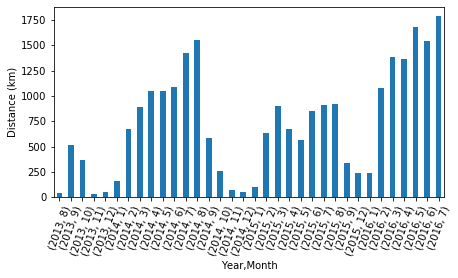

In [25]:
%%time
figsize=(7, 3.5)

tracks_grouped = tracks.groupby(['Year', 'Month'])
ax = tracks_grouped['Length'].sum().plot(kind='bar', figsize=figsize)
xlabels = [text.get_text() for text in  ax.get_xticklabels()]
ax.set_xticklabels(xlabels, rotation=70)
_ = ax.set_ylabel('Distance (km)')


If the athlete's goal was to cover over 1750 km per month. The graph above would give them some negative feedback.

Wall time: 441 ms


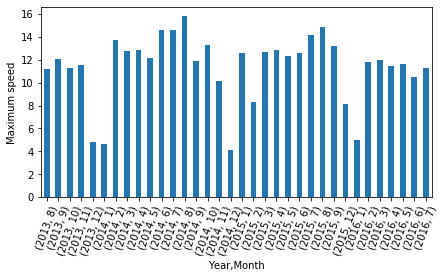

In [26]:
%%time
figsize=(7, 3.5)

tracks_grouped = tracks.groupby(['Year', 'Month'])
ax = tracks_grouped['Max_Speed'].mean().plot(kind='bar', figsize=figsize)
xlabels = [text.get_text() for text in  ax.get_xticklabels()]
ax.set_xticklabels(xlabels, rotation=70)
_ = ax.set_ylabel('Maximum speed')

The graph above shows that the athlete never moved at a speed higher than 16 km per hr. 

Wall time: 306 ms


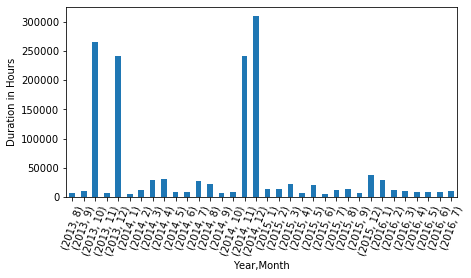

In [27]:
%%time
figsize=(7, 3.5)

tracks_grouped = tracks.groupby(['Year', 'Month'])
ax = tracks_grouped['Duration'].mean().plot(kind='bar', figsize=figsize)
xlabels = [text.get_text() for text in  ax.get_xticklabels()]
ax.set_xticklabels(xlabels, rotation=70)
_ = ax.set_ylabel('Duration in Hours')

This data shows that in certain months the athlete spent about 300,000 hours working out. Which is almost half a month.

This may suggest that they might have been preparing for a competition during that period.